# Normative atlas code

## Setup
Imports, loading

In [64]:
from glob import glob
import os
import sys

code_path = os.path.dirname(os.getcwd())
sys.path.append(code_path)

import warnings
import json
from os.path import join as ospj

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.io import loadmat
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import tools
from tools.get_network_coherence_from_data import get_network_coherence_from_data
from tools.get_atlas_bandpower_from_data import get_atlas_bandpower_from_data

warnings.filterwarnings("ignore")


In [65]:
with open("../config.json", 'rb') as f:
    config = json.load(f)
repo_path = config['repositoryPath']
metadata_path = ospj(repo_path, "ieeg-metadata")
data_path = ospj(repo_path, 'data')

bands = [
    [0.5, 4],  # delta
    [4, 8],  # theta
    [8, 12],  # alpha
    [12, 30],  # beta
    [30, 80],  # gamma
    [0.5, 80],  # broad
]
band_names = ["delta", "theta", "alpha", "beta", "gamma", "broad"]
N_BANDS = len(band_names)

## Main


In [66]:
DropLabels = [
    "Unknown",
    "Left-Cerebral-White-Matter",
    "Left-Lateral-Ventricle",
    "Left-Inf-Lat-Vent",
    "Left-Cerebellum-White-Matter",
    "Left-Cerebellum-Cortex",
    "3rd-Ventricle",
    "4th-Ventricle",
    "Brain-Stem",
    "CSF",
    "Left-choroid-plexus",
    "Right-Cerebral-White-Matter",
    "Right-Lateral-Ventricle",
    "Right-Inf-Lat-Vent",
    "Right-Cerebellum-White-Matter",
    "Right-Cerebellum-Cortex",
    "Right-choroid-plexus",
    "WM-hypointensities",
    "Optic-Chiasm",
    "CC_Posterior",
    "CC_Mid_Posterior",
    "CC_Central",
    "CC_Mid_Anterior",
    "CC_Anterior",
    "ctx-lh-unknown",
    "ctx-lh-corpuscallosum",
    "ctx-rh-unknown",
    "ctx-rh-corpuscallosum",
    "Left-VentralDC",
    "Left-vessel",
    "Right-VentralDC",
    "Right-vessel",
]
LUT = pd.read_csv(ospj(metadata_path, "roiDKT.csv"))
norm_atlas = loadmat(ospj(data_path, "norm_atlas", "atlas_data.mat"))
norm_labels = pd.read_csv(
    ospj(data_path, "norm_atlas", "norm_labels.csv"),
    names=["region", "index"],
    skiprows=1,
)
norm_coords = norm_atlas["norm_coords"]
norm_pts = norm_atlas["norm_pts"]
norm_wake_data = norm_atlas["norm_wake_data"]
norm_atlas = pd.concat(
    [
        norm_labels,
        pd.DataFrame(norm_coords, columns=["x", "y", "z"]),
        pd.Series(norm_pts.flatten(), name="patient"),
    ],
    axis=1,
)
norm_atlas.index.name = "elec"
AllROIs = norm_atlas["region"].unique()

In [67]:
## values in lookup table not in normative atlas
LUT[~LUT['roi_DKT'].isin(AllROIs)]

,SNo,Abbvr,roi_DKT,Lobe,isSideLeft,parcelNum
0,1,Tha_L,Left-Thalamus-Proper,Subcortical,1,10
6,7,Acc_L,Left-Accumbens-area,Subcortical,1,26
7,8,Tha_R,Right-Thalamus-Proper,Subcortical,0,49
10,11,Pal_R,Right-Pallidum,Subcortical,0,52
45,46,Tpole_L,ctx-lh-temporalpole,Temporal,1,1033
78,79,Fpole_R,ctx-rh-frontalpole,Frontal,0,2032
79,80,Tpole_R,ctx-rh-temporalpole,Temporal,0,2033


In [68]:
## rois in norm atlas ignored in lookup table
AllROIs[~np.array([r in LUT['roi_DKT'].values for r in AllROIs])]
# AllROIs[np.array([r in DropLabels for r in AllROIs])]

array(['Left-VentralDC', 'Left-Thalamus'], dtype=object)

In [69]:
T_step = np.linspace(0, 60, norm_wake_data.shape[0], endpoint=False)
norm_wake_data = pd.DataFrame(
    norm_wake_data,
    index=T_step,
)
norm_wake_data.index.name = "time"
norm_wake_data= norm_wake_data.rename_axis('elec', axis='columns')
norm_wake_data

elec,0,1,2,3,4,5,6,7,8,9,...,2416,2417,2418,2419,2420,2421,2422,2423,2424,2425
time,,,,,,,,,,,,,,,,,,,,,
0.000,9.760481,1.786559,-6.125683,15.464720,-12.788746,4.561216,-17.421616,-5.047136,25.915138,0.491097,...,35.761772,-38.199715,18.560982,-12.633812,-7.669916,-26.150982,62.816444,-1.245886,40.281105,23.185690
0.005,6.962562,2.879199,0.656166,13.797450,-7.868373,4.216820,-12.203720,-6.131204,19.310585,14.692173,...,36.418339,-39.168739,37.537479,-9.418370,-10.779136,-23.193060,57.187977,-0.663770,40.907379,-7.554497
0.010,13.338850,1.345329,3.346991,10.442187,-3.320182,0.239358,-12.148522,-4.275463,25.682901,23.548159,...,34.950039,-33.575249,55.551876,-7.778132,-4.491455,-4.331748,47.612537,-7.885915,39.172142,-46.143135
0.015,13.656145,0.428696,8.153217,12.581241,7.003025,-11.146839,-12.185685,-1.866495,26.483751,23.688663,...,26.315886,-23.606007,65.375076,-5.744431,-0.969450,1.264270,43.039963,-15.211549,21.707752,-63.582008
0.020,6.808327,4.177046,7.262386,14.458048,-4.506790,-3.551096,-16.863089,1.526245,24.666601,25.101496,...,16.285606,-7.993700,61.090855,-1.260967,0.442657,0.279612,41.842987,-12.821995,2.059434,-76.430267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59.975,5.922787,-1.805216,28.712793,-46.738747,19.733587,-3.424202,-0.743923,4.328961,16.842701,-30.202265,...,-18.882767,78.253716,-74.710571,-21.813248,0.079354,-29.383808,-1.475002,16.401140,28.026445,-25.562052
59.980,2.366909,-3.141341,19.111290,-37.790127,22.746519,-5.526709,-8.744895,4.546927,8.547101,-11.316814,...,-18.692633,66.570747,-67.755028,-19.412725,-5.280225,-6.962267,-2.604973,20.881815,20.743977,-48.634609
59.985,-0.601557,-5.640097,13.413164,-29.781437,6.367667,2.628549,-23.100426,11.837245,-4.507789,20.552982,...,-17.698641,60.407143,-71.385170,-15.652177,-6.871209,-0.538698,-5.734267,19.565931,25.400471,-76.577881


In [70]:
bandpower = get_atlas_bandpower_from_data(norm_wake_data)
bandpower.index.name='freq'
bandpower.rename_axis('elec', axis='columns', inplace=True)

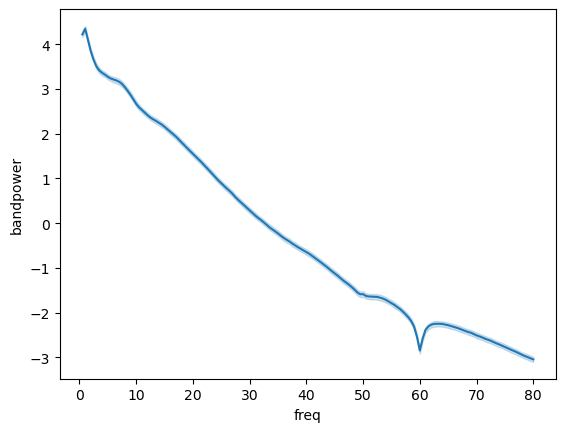

In [71]:
logpower = pd.merge(
    norm_atlas.reset_index(),
    bandpower.apply(lambda x: np.log(x)
    ).stack().rename("bandpower").reset_index(),
    on="elec",
)
plt.close("all")
sns.lineplot(data=logpower, x="freq", y="bandpower")
plt.show()


In [72]:
logpower.to_pickle(ospj(data_path, "norm_logpower.pkl"))

In [73]:
bandpower.stack().rename('bandpower').reset_index().groupby('elec').get_group(1)

,freq,elec,bandpower
1,0.5,1,19.654247
2427,1.0,1,19.345331
4853,1.5,1,15.555434
7279,2.0,1,9.085543
9705,2.5,1,5.575990
...,...,...,...
376031,78.0,1,0.025112
378457,78.5,1,0.031097
380883,79.0,1,0.030449
383309,79.5,1,0.022094


In [74]:
bp_groups = bandpower.stack().rename('bandpower').reset_index().groupby('elec').apply(lambda x: tools.format_bandpower(x))


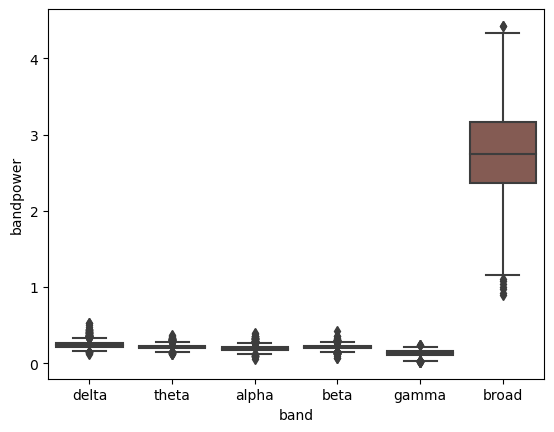

In [75]:
norm_power = pd.merge(
    norm_atlas.reset_index(),
    bp_groups
    .stack()
    .rename("bandpower")
    .reset_index(),
    on="elec",
)
plt.close("all")
sns.boxplot(data = norm_power, x = 'band', y='bandpower', showfliers =True)
plt.show()

In [76]:
norm_power.to_pickle(ospj(data_path, 'Norm_Power.pkl'))

In [77]:
all_conn = np.empty((N_BANDS, len(AllROIs), len(AllROIs), 0)).tolist()

for i, (pt, data) in enumerate(norm_atlas.reset_index().groupby("patient")):
    print(i, pt)
    elecs = data["elec"]
    roi = data["region"]
    if len(elecs) > 1:
        nxx = get_network_coherence_from_data(norm_wake_data.loc[:, elecs])
        n_channels = len(np.unique(nxx.index.to_frame().to_numpy().ravel()))
        for n in range(N_BANDS):
            for i, j in itertools.combinations(range(n_channels), 2):
                roi_i = np.where(AllROIs == roi.iloc[i])[0][0]
                roi_j = np.where(AllROIs == roi.iloc[j])[0][0]
                all_conn[n][roi_i][roi_j].append(
                    nxx.loc[elecs.iloc[i]].loc[elecs.iloc[j]].iloc[n]
                )
                all_conn[n][roi_j][roi_i].append(
                    nxx.loc[elecs.iloc[i]].loc[elecs.iloc[j]].iloc[n]
                )


0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 52
51 53
52 54
53 55
54 56
55 57
56 58
57 59
58 60
59 61
60 62
61 63
62 64
63 65
64 66
65 67
66 68
67 69
68 70
69 71
70 72
71 73
72 74
73 75
74 76
75 77
76 78
77 79
78 80
79 81
80 82
81 83
82 84
83 85
84 87
85 88
86 89
87 90
88 91
89 92
90 93
91 94
92 96
93 97
94 98
95 99
96 100
97 101
98 102
99 103
100 104
101 106
102 107
103 108
104 109
105 110
106 111
107 112
108 113
109 117
110 118
111 120
112 121
113 122
114 123
115 124
116 125
117 126
118 127
119 128
120 129
121 132
122 133
123 134
124 135
125 136
126 137
127 140
128 143
129 144
130 145
131 146
132 147
133 148
134 149
135 150
136 152
137 154
138 156
139 157
140 163
141 166


In [78]:
all_conn= np.array(all_conn)

N_true = 0
N_false = 0 
Mean = np.zeros((N_BANDS, len(AllROIs), len(AllROIs)))
Std = Mean.copy()
Num = Mean.copy()
x, y = np.tril_indices_from(all_conn[-1, :,:])
for i, j in zip(x,y):
    if all_conn[-1, i, j]:
        print(AllROIs[i], AllROIs[j], ':', len(all_conn[-1, i, j]))
    else:
        print(AllROIs[i], AllROIs[j], ': none')
for n, i, j in itertools.product(range(N_BANDS), range(len(AllROIs)), range(len(AllROIs))):
    if all_conn[n, i, j]:
        Mean[n,i,j] = np.mean(all_conn[n, i, j])
        Std[n,i,j] =   np.std(all_conn[n, i, j])
        Num[n,i,j] = len(all_conn[n, i, j])
    else:
        Mean[n,i,j] = np.nan
        Std[n,i,j] =  np.nan
        Num[n,i,j] = 0

ctx-lh-middletemporal ctx-lh-middletemporal : 210
ctx-rh-medialorbitofrontal ctx-lh-middletemporal : 7
ctx-rh-medialorbitofrontal ctx-rh-medialorbitofrontal : 6
ctx-lh-medialorbitofrontal ctx-lh-middletemporal : 52
ctx-lh-medialorbitofrontal ctx-rh-medialorbitofrontal : 13
ctx-lh-medialorbitofrontal ctx-lh-medialorbitofrontal : 32
ctx-lh-superiortemporal ctx-lh-middletemporal : 78
ctx-lh-superiortemporal ctx-rh-medialorbitofrontal : 16
ctx-lh-superiortemporal ctx-lh-medialorbitofrontal : 29
ctx-lh-superiortemporal ctx-lh-superiortemporal : 284
ctx-rh-posteriorcingulate ctx-lh-middletemporal : 1
ctx-rh-posteriorcingulate ctx-rh-medialorbitofrontal : none
ctx-rh-posteriorcingulate ctx-lh-medialorbitofrontal : 1
ctx-rh-posteriorcingulate ctx-lh-superiortemporal : 3
ctx-rh-posteriorcingulate ctx-rh-posteriorcingulate : 8
ctx-rh-precentral ctx-lh-middletemporal : none
ctx-rh-precentral ctx-rh-medialorbitofrontal : 5
ctx-rh-precentral ctx-lh-medialorbitofrontal : 1
ctx-rh-precentral ctx-lh-s

In [79]:
MeanConn = (
    pd.concat([pd.DataFrame(i) for i in Mean], keys=band_names)
    .stack()
    .rename_axis(["band", "roi_from", "roi_to"])
    .rename(index=dict(zip(range(len(AllROIs)), AllROIs)), level=1)
    .rename(index=dict(zip(range(len(AllROIs)), AllROIs)), level=2)
)
StdConn = (
    pd.concat([pd.DataFrame(i) for i in Std], keys=band_names)
    .stack()
    .rename_axis(["band", "roi_from", "roi_to"])
    .rename(index=dict(zip(range(len(AllROIs)), AllROIs)), level=1)
    .rename(index=dict(zip(range(len(AllROIs)), AllROIs)), level=2)
)
NumConn = (
    pd.concat([pd.DataFrame(i) for i in Num], keys=band_names)
    .stack()
    .rename_axis(["band", "roi_from", "roi_to"])
    .rename(index=dict(zip(range(len(AllROIs)), AllROIs)), level=1)
    .rename(index=dict(zip(range(len(AllROIs)), AllROIs)), level=2)
)
AllConn = pd.concat([MeanConn, StdConn, NumConn], keys = ['mean', 'std', 'num'], names=['value'])
AllConn=AllConn.unstack('value').set_index('num', append=True).unstack('band')
AllConn

value                                                         mean            \
band                                                         alpha      beta   
roi_from                  roi_to                    num                        
Left-Amygdala             Left-Amygdala             0.0        NaN       NaN   
                          Left-Caudate              0.0        NaN       NaN   
                          Left-Hippocampus          4.0   0.136039  0.069648   
                          Left-Pallidum             0.0        NaN       NaN   
                          Left-Putamen              0.0        NaN       NaN   
...                                                            ...       ...   
ctx-rh-transversetemporal ctx-rh-superiorfrontal    0.0        NaN       NaN   
                          ctx-rh-superiorparietal   0.0        NaN       NaN   
                          ctx-rh-superiortemporal   10.0  0.027612  0.021117   
                          ctx-rh-supramarginal      12.0  0.082476  0.030515   
                          ctx-rh-transversetemporal 2.0   0.068912  0.286051   

value                                                                         \
band                                                         broad     delta   
roi_from                  roi_to                    num                        
Left-Amygdala             Left-Amygdala             0.0        NaN       NaN   
                          Left-Caudate              0.0        NaN       NaN   
                          Left-Hippocampus          4.0   0.056520  0.176349   
                          Left-Pallidum             0.0        NaN       NaN   
                          Left-Putamen              0.0        NaN       NaN   
...                                                            ...       ...   
ctx-rh-transversetemporal ctx-rh-superiorfrontal    0.0        NaN       NaN   
                          ctx-rh-superiorparietal   0.0        NaN       NaN   
                          ctx-rh-superiortemporal   10.0  0.021281  0.026747   
                          ctx-rh-supramarginal      12.0  0.026908  0.025089   
                          ctx-rh-transversetemporal 2.0   0.437199  0.158564   

value                                                                         \
band                                                         gamma     theta   
roi_from                  roi_to                    num                        
Left-Amygdala             Left-Amygdala             0.0        NaN       NaN   
                          Left-Caudate              0.0        NaN       NaN   
                          Left-Hippocampus          4.0   0.030802  0.122664   
                          Left-Pallidum             0.0        NaN       NaN   
                          Left-Putamen              0.0        NaN       NaN   
...                                                            ...       ...   
ctx-rh-transversetemporal ctx-rh-superiorfrontal    0.0        NaN       NaN   
                          ctx-rh-superiorparietal   0.0        NaN       NaN   
                          ctx-rh-superiortemporal   10.0  0.020310  0.022321   
                          ctx-rh-supramarginal      12.0  0.020544  0.042370   
                          ctx-rh-transversetemporal 2.0   0.563413  0.161938   

value                                                          std            \
band                                                         alpha      beta   
roi_from                  roi_to                    num                        
Left-Amygdala             Left-Amygdala             0.0        NaN       NaN   
                          Left-Caudate              0.0        NaN       NaN   
                          Left-Hippocampus          4.0   0.179365  0.056190   
                          Left-Pallidum             0.0        NaN       NaN   
                          Left-Putamen              0.0        NaN       NaN 

In [80]:
AllConn.to_pickle(ospj(data_path, 'NormAllConnect.pkl'))